<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Building and Running Quantum Circuits

The `QuantumCircuit`, `QuantumRegister`, and `ClassicalRegister` are the main objects for Qiskit Terra. Most users will be able to do all they want with these objects. 

In [44]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer, Aer, IBMQ, execute
from qiskit.quantum_info import Pauli, state_fidelity, basis_state, process_fidelity 
from qiskit.visualization import plot_histogram

## Quantum and Classical Registers

Quantum and Classical Registers are declared using the following:

In [2]:
q0 = QuantumRegister(2, 'q0')
c0 = ClassicalRegister(2, 'c0')
q1 = QuantumRegister(2, 'q1')
c1 = ClassicalRegister(2, 'c1')
q_test = QuantumRegister(2, 'q0')

The name is optional. If not given, Qiskit will name it $qi$, where $i$ is an interger which will count from 0. The name and size can be returned using the following:

In [3]:
print(q0.name)
print(q0.size)

q0
2


You can test if the registers are the same or different. 

In [4]:
q0==q0

True

In [5]:
q0==q_test

True

In [6]:
q0==q1

False

## Quantum Circuits

Quantum Circuits are made using registers, which are created either when initiated or by using the `add_register` command. 

In [7]:
circ = QuantumCircuit(q0, q1)
circ.x(q0[1])
circ.x(q1[0])
circ.draw()

is the same as 

In [8]:
circ2 = QuantumCircuit()
circ2.add_register(q0)
circ2.add_register(q1)
circ2.x(q0[1])
circ2.x(q1[0])
circ2.draw()

<div class="alert alert-block alert-info">
<b>Note:</b> The registers are listed in the order they are initiated or added (**not** the tensor product for quantum registers).
</div>

In [9]:
from copy import deepcopy

q3 = QuantumRegister(2, 'q3')
circ3 = deepcopy(circ)
circ3.add_register(q3)
circ3.draw()

<div class="alert alert-block alert-info">
<b>Note:</b> The circuit drawer has the last register added at the bottom. If we add a new register it will add it to the bottom of the circuit. 
</div>

### Extending a circuit

In many situations you may have two circuits that you want to concatenate to form a new circuit. This is very useful when one circuit has no measurements, and the final circuit represents a measurement.  

In [10]:
meas = QuantumCircuit(q0, q1, c0, c1)
meas.measure(q0, c0)
meas.measure(q1, c1)

qc = circ + meas

qc.draw()

In [11]:
meas2 = QuantumCircuit()
meas2.add_register(q0)
meas2.add_register(q1)
meas2.add_register(c0)
meas2.add_register(c1)
meas2.measure(q0, c0)
meas2.measure(q1, c1)

qc2 = circ2 + meas2

qc2.draw()

It even works when the circuits have different registers. Let's start by making two new circuits:

In [12]:
circ4 = QuantumCircuit(q1)
circ4.x(q1)
circ4.draw()

In [13]:
circ5 = QuantumCircuit(q3)
circ5.h(q3)
circ5.draw()

The new register is added to the circuit:

In [14]:
(circ4+circ5).draw()

We have also overloaded `+=` to the `QuantumCircuit` object:

In [15]:
circ4 += circ5
circ4.draw()

## Outcomes of Quantum Circuits

In the circuit output, the most significant bit (MSB) is to the left, and the least significant bit (LSB) is to the right (i.e., we follow little-endian ordering from computer science). In this example:

In [16]:
circ.draw()

qubit register $Q_0$ is prepared in the state $|10\rangle$ and $Q_1$ is in the state $|01\rangle$, giving a total state $|0110\rangle$ ($Q1\otimes Q0$). 

<div class="alert alert-block alert-info">
<b>Note:</b> The tensor order in Qiskit goes as $Q_n \otimes .. Q_1 \otimes Q_0$
</div>

That is the four-qubit statevector of length 16, with the sixth element (`int('0110',2)=6`) being one. Note the element count starts from zero.

In [17]:
backend_sim = BasicAer.get_backend('statevector_simulator')
result = execute(circ, backend_sim).result()
state = result.get_statevector(circ)
print(state)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


To check the fidelity of this state with the `basis_state` in Qiskit Terra, use:

In [18]:
state_fidelity(basis_state('0110', 4), state)

1.0

We can also use Qiskit Terra to make the unitary operator representing the circuit (provided there are no measurements). This will be a $16\otimes16$ matrix equal to $I\otimes X\otimes X\otimes I$. To check this is correct, we can use the `Pauli` class and the `process_fidelity` function. 

In [19]:
backend_sim = BasicAer.get_backend('unitary_simulator')
result = execute(circ, backend_sim).result()
unitary = result.get_unitary(circ)
process_fidelity(Pauli(label='IXXI').to_matrix(), unitary)

(1+0j)

To map the information of the quantum state to the classial world, we use the example with measurements `qc`:

In [20]:
qc.draw()

This will map the quantum state to the classical world. Since the state has no superpositions, it will be deterministic and equal to `'01 10'`.  Here a space is used to separate the registers.

In [21]:
backend_sim = BasicAer.get_backend('qasm_simulator')
result = execute(qc, backend_sim).result()
counts = result.get_counts(qc)
print(counts)

{'01 10': 1024}


To show that it does not matter how you add the registers, we run the same as above on the second example circuit:

In [22]:
backend_sim = BasicAer.get_backend('statevector_simulator')
result = execute(circ2, backend_sim).result()
states = result.get_statevector(circ2)

backend_sim = BasicAer.get_backend('qasm_simulator')
result = execute(qc2, backend_sim, shots=1024).result()
counts = result.get_counts(qc2)

backend_sim = BasicAer.get_backend('unitary_simulator')
result = execute(circ2, backend_sim, shots=1024).result()
unitary = result.get_unitary(circ2)

In [23]:
print(counts)

{'01 10': 1024}


In [24]:
state_fidelity(basis_state('0110', 4), state)

1.0

## Aer vs BasicAer

`BasicAer` and `Aer` are simulator `Provider`s in the sameway that `IBMQ` is a provider for our physical devices. `Aer` is a high-performance C++ provider, whereas `BasicAer` is implemented in Python

<span class="badge badge-primary">Exercise 1.0</span> Try comparing the results of a random quantum circuit with ~1000 gates executed with both `Aer` and `BasicAer` for 14 qubits. The rough steps to this are

1. Import the required simulators from `BasicAer` and `Aer`.
2. Create your `QuantumRegister`, `ClassicalRegister` and `QuantumCircuit`
3. Add 1000 random gates
4. Submit the job and ask for the result. We encourage you to time the results.
5. Get the counts from the results and compare them.

In [37]:
basicaer_backend_sim = BasicAer.get_backend('qasm_simulator')
aer_backend_sim = Aer.get_backend('qasm_simulator')

n_qubits = 14

qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
qc_benchmark = QuantumCircuit(qr, cr)

for i in range(1000):
    random_qubit = np.random.randint(0, n_qubits)
    qc_benchmark.x(qr[random_qubit])

qc_benchmark.measure(qr, cr)

print('Basic Aer')
%time basic_aer_counts = execute(qc_benchmark, basicaer_backend_sim).result().get_counts(qc_benchmark)

print('Aer')
%time aer_counts = execute(qc_benchmark, aer_backend_sim).result().get_counts(qc_benchmark)

print(basic_aer_counts)
print(aer_counts)

Basic Aer
CPU times: user 1.12 s, sys: 9.89 ms, total: 1.13 s
Wall time: 1.13 s
Aer
CPU times: user 570 ms, sys: 23 ms, total: 593 ms
Wall time: 522 ms
{'01100100001000': 1024}
{'01100100001000': 1024}


## Real device results

<span class="badge badge-primary">Exercise 1.1</span> Now try and run the same circuit on the real device, `ibmq_16_melbourne`.

Remember to load your credentials with the `IBMQ` provider and to grab a handle to the backend `ibmq_16_melbourne`.

<div class="alert alert-block alert-info">
<b>Note:</b> This may take a while if you all send your jobs together.
</div>

In [41]:
IBMQ.load_accounts()
melbourne_backend = IBMQ.get_backend('ibmq_16_melbourne')

print(melbourne_backend.name())
%time melbourne_counts = execute(qc_benchmark, melbourne_backend).result().get_counts(qc_benchmark)
print(melbourne_counts) 

/Users/talexander/anaconda3/envs/qiskit-test/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:272: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


ibmq_16_melbourne
CPU times: user 3.94 s, sys: 82.2 ms, total: 4.02 s
Wall time: 5min 50s


<span class="badge badge-primary">Exercise 1.2</span> Compare the physical device results to the ideal simulation. You can use the `plot_histogram` method to better visualize the results.

<div class="alert alert-block alert-info">
<b>Note:</b> Use 'help' to get more information on how to use 'plot_histogram'. Try playing with the 'number_to_keep' option.
</div>

- What do you see? 
- Why do you think the results differ? 
- Why do we even bother trying to build a quantum computer if the results are so bad?

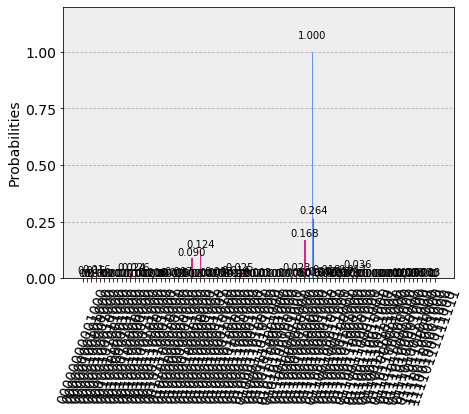

In [66]:
plot_histogram([aer_counts, melbourne_counts])

<span class="badge badge-primary">Exercise 1.3</span> Perform the same exeperiment with only 100 gates. Do the results change

Basic Aer
CPU times: user 160 ms, sys: 4.87 ms, total: 164 ms
Wall time: 162 ms
Aer
CPU times: user 102 ms, sys: 5.62 ms, total: 107 ms
Wall time: 71.9 ms
ibmq_16_melbourne
CPU times: user 14.3 s, sys: 1.2 s, total: 15.5 s
Wall time: 1h 37min 30s
{'00001101110010': 1024}
{'00001101110010': 1024}
{'00000100110010': 1, '00001101111011': 8, '00101111111010': 8, '01101101110010': 15, '10101100010010': 1, '00011101110010': 3, '10101111111010': 1, '10101101110010': 6, '00011101110000': 1, '10101101111001': 1, '01001011110010': 1, '00100001111011': 1, '00101101100011': 1, '01011101111010': 1, '01101111110010': 1, '00001101001010': 1, '00001001100010': 1, '00001101010000': 3, '10000101100010': 1, '10100101010000': 1, '00101100111010': 2, '10010101111010': 1, '00101100010010': 1, '00101111100011': 1, '01001000110010': 1, '01001101100010': 1, '00000100111010': 1, '01101000111010': 1, '00101101011010': 1, '10001100110010': 2, '00001100100010': 2, '00001101110010': 268, '00001101101010': 1, '00001

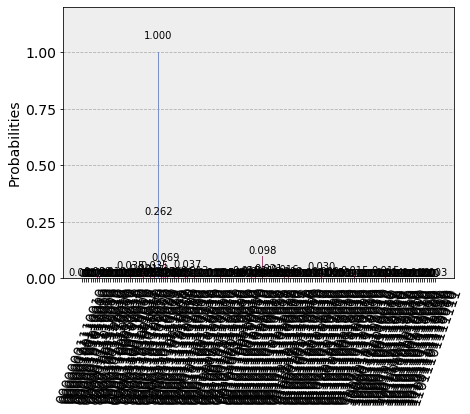

In [67]:
basicaer_backend_sim = BasicAer.get_backend('qasm_simulator')
aer_backend_sim = Aer.get_backend('qasm_simulator')

qc_benchmark_100 = QuantumCircuit(qr, cr)

for i in range(100):
    random_qubit = np.random.randint(0, n_qubits)
    qc_benchmark_100.x(qr[random_qubit])

qc_benchmark_100.measure(qr, cr)

print('Basic Aer')
%time basic_aer_counts_100 = execute(qc_benchmark_100, basicaer_backend_sim).result().get_counts(qc_benchmark_100)

print('Aer')
%time aer_counts_100 = execute(qc_benchmark_100, aer_backend_sim).result().get_counts(qc_benchmark_100)

print(melbourne_backend.name())
%time melbourne_counts_100 = execute(qc_benchmark_100, melbourne_backend).result().get_counts(qc_benchmark_100)
 
print(basic_aer_counts_100)
print(aer_counts_100)
print(melbourne_counts_100)

plot_histogram([aer_counts_100, melbourne_counts_100])